In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
import numpy as np
import matplotlib.pyplot as plt

def classify(model, tokenizer, texts, device="cuda:1", logit_threshold=4):
    # Set the model to evaluate mode
    model.eval()

    # Tokenize the input sentences and create input tensors for the model
    inputs = tokenizer(
            texts,
            truncation=True,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_tensors="pt")

    # Pass the inputs through the model to get the predicted labels
    labels = []
    with torch.no_grad():
        outputs = model(inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
        logits = outputs.logits.detach().cpu().numpy()
        # If the first logit is greater than 3, append 1 (True) to the labels list, else append 0 (False)
        labels.append([1 if logit[0] > logit_threshold else 0 for logit in logits])

    return labels

def datapoints(df, model, tokenizer, logit):
    labels = []
    for i, row in df.iterrows():
        labels.append(classify(model,tokenizer,row["text"], logit_threshold=logit))
    return labels
    
 
    
    


In [36]:
model = "/scratch/venia/socialgpt/venia_worker_vs_gpt/models/gpturk_transductive_size:766_intfloat/e5-base/checkpoint-576"
# model = "/scratch/venia/socialgpt/venia_worker_vs_gpt/models/gpturk_inductive_size:182_intfloat/e5-base/checkpoint-460"


In [23]:
device = "cuda:1"
df = pd.read_csv("../data/processed_responses.csv")



In [38]:
worker_ids = pd.read_csv("../data/worker_id_summary.csv")
df = df.merge(worker_ids, on="summary", how="inner").drop_duplicates(subset="summary")

In [39]:
# df = df[df["summary"].map(len) > 20]

In [40]:
df = df.rename({"summary":"text"}, axis=1)

In [41]:
mapping = {1: "synthetic", 0: "real"}

### Logit = 4

In [8]:
# df = pd.read_csv("/scratch/venia/socialgpt/SocialSynth/data/sarcasm/synth/Train-SynthReal.csv").sample(10)
model = AutoModelForSequenceClassification.from_pretrained(model).to(device)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base")
labels = datapoints(df, model, tokenizer, 4)


In [9]:
df["predicted"] = [mapping[k[0][0]] for k in labels]


In [10]:
df.groupby("predicted")["key_strokes"].count()

predicted
real         31
synthetic    15
Name: key_strokes, dtype: int64

In [13]:
df.drop_duplicates("WorkerId").groupby("predicted")["key_strokes"].count()

predicted
real         28
synthetic    14
Name: key_strokes, dtype: int64

In [ ]:
df.to_csv("../data/processed_responses_with_predictions_abstract_level.csv", index=False)

## Logit = 0

In [17]:
# df = pd.read_csv("/scratch/venia/socialgpt/SocialSynth/data/sarcasm/synth/Train-SynthReal.csv").sample(10)
model = AutoModelForSequenceClassification.from_pretrained(model).to(device)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base")
labels = datapoints(df, model, tokenizer, 0)


In [18]:
df["logit_0"] = [mapping[k[0][0]] for k in labels]


In [19]:
df.groupby("logit_0")["key_strokes"].count()

logit_0
real         25
synthetic    21
Name: key_strokes, dtype: int64

### Bootstrap the results: transductive

In [43]:
model = "/scratch/venia/socialgpt/venia_worker_vs_gpt/models/gpturk_transductive_size:766_intfloat/e5-base/checkpoint-576"

# df = pd.read_csv("/scratch/venia/socialgpt/SocialSynth/data/sarcasm/synth/Train-SynthReal.csv").sample(10)
model = AutoModelForSequenceClassification.from_pretrained(model).to(device)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base")


In [486]:
test = pd.read_json("../data/test_transductive.json", orient="records")

In [22]:
# bootstrap proportion synthetic
synthetic_counts_4 = []

for i in range(30):
    temp = df.sample(frac=1, replace=True)
    labels = datapoints(temp, model, tokenizer, 4)
    
    synth_count = 0
    for label in labels:
        prediction = mapping[label[0][0]]
        if prediction == "synthetic":
            synth_count += 1
    
    synthetic_counts_4.append(synth_count)

In [23]:
# bootstrap proportion synthetic
synthetic_counts_0 = []

for i in range(30):
    temp = df.sample(frac=1, replace=True)
    labels = datapoints(temp, model, tokenizer, 0)
    
    synth_count = 0
    for label in labels:
        prediction = mapping[label[0][0]]
        if prediction == "synthetic":
            synth_count += 1
    
    synthetic_counts_0.append(synth_count)

In [26]:
frac = [k / len(df) for k in synthetic_counts_4]
np.std(frac)

0.06268848914168744

In [27]:
frac = [k / len(df) for k in synthetic_counts_0]
np.std(frac)

0.07570990079193611

In [522]:
og_predictions = datapoints(test, model, tokenizer, 4)

In [531]:
# bootstrap proportion synthetic
all_labels = []

for i in range(50):
    temp = test.sample(frac=1, replace=True)
    labels = datapoints(temp, model, tokenizer, 0)
    all_labels.append([temp["labels"].values.tolist(), labels])
    
#     test_counts.append(synth_count)

In [503]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [541]:


for l in [og_predictions]:
    preds = [mapping[k[0][0]] for k in l]
    y = test["labels"]
    
    og_f1_score = f1_score(y, preds, average="macro")
    og_accuracy_score = accuracy_score(y, preds)
    og_precision_score = precision_score(y, preds, average="macro")
    og_recall_score = recall_score(y, preds, average="macro")
    
    print("Original f1 score: ", og_f1_score)
    print("Original accuracy score: ", og_accuracy_score)
    print("Original precision score: ", og_precision_score)
    print("Original recall score: ", og_recall_score)

    

Original f1 score:  0.9887357940259479
Original accuracy score:  0.9910714285714286
Original precision score:  0.9939024390243902
Original recall score:  0.9838709677419355


In [533]:
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []


for l in all_labels:
    preds = [mapping[k[0][0]] for k in l[1]]
    y = l[0]
    
    f1_scores.append(f1_score(y, preds, average="macro"))
    accuracy_scores.append(accuracy_score(y, preds))
    precision_scores.append(precision_score(y, preds, average="macro"))
    recall_scores.append(recall_score(y, preds, average="macro"))

for name, score in zip(["f1", "accuracy", "precision", "recall"], [f1_scores, accuracy_scores, precision_scores, recall_scores]):
    print(name) 
    print(2*np.std(score))
    
    

f1
0.030714585004498626
accuracy
0.024849033981141386
precision
0.01725950481266866
recall
0.04103829506313947


### Bootstrap the results: abstract-level

In [582]:
model = "/scratch/venia/socialgpt/venia_worker_vs_gpt/models/gpturk_inductive_size:182_intfloat/e5-base/checkpoint-92"

# df = pd.read_csv("/scratch/venia/socialgpt/SocialSynth/data/sarcasm/synth/Train-SynthReal.csv").sample(10)
model = AutoModelForSequenceClassification.from_pretrained(model).to(device)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base")


In [583]:
test = pd.read_json("../data/test_inductive.json", orient="records")

In [584]:
og_predictions = datapoints(test, model, tokenizer, 0)

In [588]:
# bootstrap proportion synthetic
all_labels_inductive = []

for i in range(25):
    temp = test.sample(frac=1, replace=True)
    labels = datapoints(temp, model, tokenizer, 0)
    all_labels_inductive.append([temp["labels"].values.tolist(), labels])
    

In [587]:
for l in [og_predictions]:
    preds = [mapping[k[0][0]] for k in l]
    y = test["labels"]
    
    og_f1_score = f1_score(y, preds, average="macro")
    og_accuracy_score = accuracy_score(y, preds)
    og_precision_score = precision_score(y, preds, average="macro")
    og_recall_score = recall_score(y, preds, average="macro")
    
    print("Original f1 score: ", og_f1_score)
    print("Original accuracy score: ", og_accuracy_score)
    print("Original precision score: ", og_precision_score)
    print("Original recall score: ", og_recall_score)

    

Original f1 score:  0.9731481481481481
Original accuracy score:  0.9770114942528736
Original precision score:  0.9731481481481481
Original recall score:  0.9731481481481481


In [574]:
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []


for l in all_labels:
    preds = [mapping[k[0][0]] for k in l[1]]
    y = l[0]
    
    f1_scores.append(f1_score(y, preds, average="macro"))
    accuracy_scores.append(accuracy_score(y, preds))
    precision_scores.append(precision_score(y, preds, average="macro"))
    recall_scores.append(recall_score(y, preds, average="macro"))

for name, score in zip(["f1", "accuracy", "precision", "recall"], [f1_scores, accuracy_scores, precision_scores, recall_scores]):
    print(name) 
    print(2*np.std(score))
    
    

f1
0.030714585004498626
accuracy
0.024849033981141386
precision
0.01725950481266866
recall
0.04103829506313947


### Logit plot

In [44]:
all_logits = np.linspace(-7,7, 25)
for logit in all_logits:
    labels = datapoints(df, model, tokenizer, logit)
    df[logit] = [mapping[k[0][0]] for k in labels]


In [45]:
def process_col(col):
    count_synthetic = df[df[col]=="synthetic"][col].count()
    return count_synthetic / 46

In [46]:
prop_synthetic = []
prop_synthetic2 = []


for logit in all_logits:
    prop_synthetic.append([np.exp(logit) / (1 + np.exp(logit)), process_col(logit)])
    prop_synthetic2.append([logit, process_col(logit)])

In [47]:
np.exp(4) / (1 + np.exp(4))

0.9820137900379085

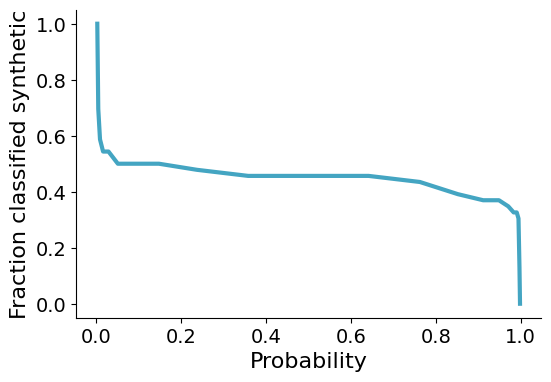

In [51]:
x = [k[0] for k in prop_synthetic][2:-1]
y = [k[1] for k in prop_synthetic][2:-1]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, y, color="#44a5c2", linewidth=3)


ax.set_ylabel("Fraction classified synthetic", fontsize=16)
ax.set_xlabel("Probability", fontsize=16)
ax.tick_params(labelsize=14)
ax.spines[['right', 'top']].set_visible(False)

# ax.axhline(0.333, xmax=.76, linestyle="--", color="black", alpha=.5, linewidth=2)

# ax.legend(frameon=False, fontsize=13)
# ax.text(x=3.6, y=.9, s="Our cutoff", ha="right", fontsize = 15)
ax.annotate(text="Our cutoff", xy=(4,-0.05), xytext=(3.3,.1), fontsize = 15,arrowprops=dict(facecolor='black', width=.3, headwidth=5, headlength=6),
            horizontalalignment='right')


# plt.savefig("../visuals/probability_plot.pdf", dpi=300, bbox_inches="tight")

plt.show()

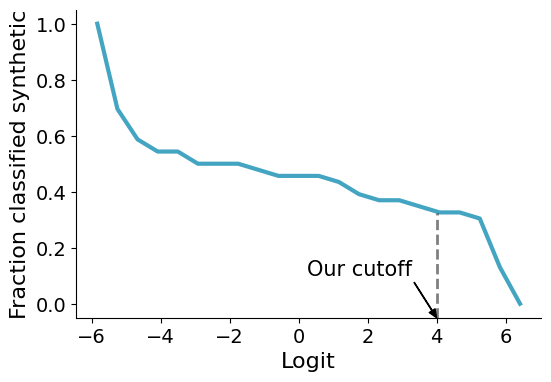

In [52]:
x = [k[0] for k in prop_synthetic2][2:-1]
y = [k[1] for k in prop_synthetic2][2:-1]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, y, color="#44a5c2", linewidth=3)


ax.set_ylabel("Fraction classified synthetic", fontsize=16)
ax.set_xlabel("Logit", fontsize=16)
ax.tick_params(labelsize=14)
ax.spines[['right', 'top']].set_visible(False)

ax.axvline(4, ymax=.34, linestyle="--", color="black", alpha=.5, linewidth=2)
# ax.axhline(0.333, xmax=.76, linestyle="--", color="black", alpha=.5, linewidth=2)

# ax.legend(frameon=False, fontsize=13)
# ax.text(x=3.6, y=.9, s="Our cutoff", ha="right", fontsize = 15)
ax.annotate(text="Our cutoff", xy=(4,-0.05), xytext=(3.3,.1), fontsize = 15,arrowprops=dict(facecolor='black', width=.3, headwidth=5, headlength=6),
            horizontalalignment='right')


# plt.savefig("../visuals/logit_plot.pdf", dpi=300, bbox_inches="tight")

plt.show()

## Plot predictions

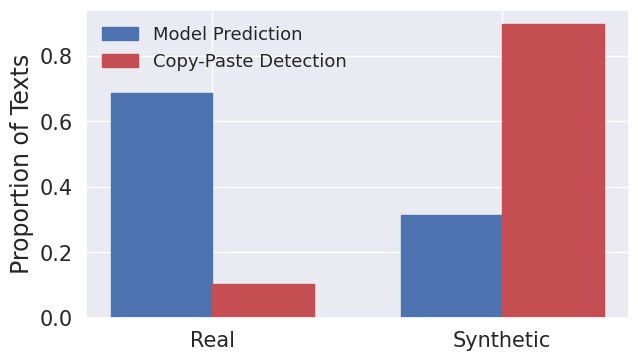

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the seaborn style is used
sns.set()

# Define the labels and proportions for each category
categories = ['Real', 'Synthetic']
model_prediction = [33/(13+35), 15/(13+35)]
copy_paste_detection = [5/(43+5), 43/(43+5)]

# Plotting
barWidth = 0.35
r1 = np.arange(len(categories)) # positions for first group of bars
r2 = [x + barWidth for x in r1] # positions for second group of bars

plt.figure(figsize=(7,4))

# Create bars for Model Prediction
plt.bar(r1, model_prediction, color='b', edgecolor='b', width=barWidth, label='Model Prediction')

# Create bars for Copy-Paste Detection (next to Model Prediction)
plt.bar(r2, copy_paste_detection, color='r', edgecolor='r', width=barWidth, label='Copy-Paste Detection')

# Custom x axis
plt.xticks([r + barWidth/2 for r in range(len(categories))], categories, fontsize=15) # use fontsize
plt.yticks(fontsize=15)
# plt.xlabel("Category", fontsize=15)
plt.ylabel("Proportion of Texts", fontsize=17)

# plt.title("Proportions of Real and Synthetic Texts Detected by Different Methods", fontsize=18)

plt.legend(fontsize=13, frameon=False)


plt.savefig("../visuals/detection.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Bar plot

In [28]:
new = pd.read_csv("../data/processed_responses_with_predictions3.csv").drop("HITId", axis=1)

In [20]:
from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.distance import JaccardIndex
from string2string.misc.default_tokenizer import Tokenizer

def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

copied = new[new["copied"] == True]
common_substr = []
for i, row in copied.iterrows():
    common_substr.append(measure_substr_length(row["original_text"], row["text"]))
    
copied["common_substr"] = common_substr

tokenizer = Tokenizer(word_delimiter=' ')

copied["original_length"] = copied["original_text"].apply(lambda x: len(tokenizer.tokenize(x)))
copied["text_length"] = copied["text"].apply(lambda x: len(tokenizer.tokenize(x)))

copied["prop_copied"] = copied["common_substr"] / copied["text_length"]

copied.sort_values(by = "prop_copied").sort_values(by = "prop_copied")


copied=copied.drop_duplicates()

/tmp/ipykernel_3566566/3992347602.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["common_substr"] = common_substr
/tmp/ipykernel_3566566/3992347602.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["original_length"] = copied["original_text"].apply(lambda x: len(tokenizer.tokenize(x)))
/tmp/ipykernel_3566566/3992347602.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

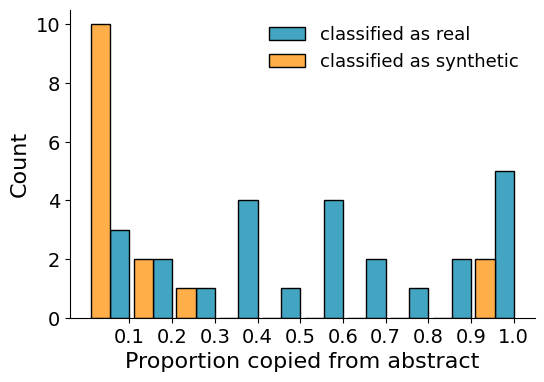

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

proportion_copied = copied.sort_values(by = "prop_copied")

# Create bins for 'prop_copied' values
bins = np.linspace(proportion_copied["prop_copied"].min(), proportion_copied["prop_copied"].max(), 11)



# Cut 'prop_copied' into bins and count the n
# bins = np.arange(0.1, 1.1, 0.1)

real_data = proportion_copied[proportion_copied["predicted"] == "real"]["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["predicted"] == "real"]["prop_copied"], bins, labels=False)).count()
synthetic_data = proportion_copied[proportion_copied["predicted"] == "synthetic"]["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["predicted"] == "synthetic"]["prop_copied"], bins, labels=False)).count()

real_data.fillna(0, inplace=True)
synthetic_data.fillna(0, inplace=True)

concatted = pd.concat([real_data, synthetic_data], axis=1).fillna(0)
concatted.columns = ["real", "synthetic"]
concatted = concatted.sort_index()
concatted.index = np.round(concatted.index / 10 + .1, 1)

fig, ax = plt.subplots(figsize=(6,4))

# Set bar width
bar_width = 0.45

# Create two arrays for the positions of the bars on the x-axis
r1 = np.arange(len(concatted["real"]))
r2 = [x + bar_width for x in r1]

# Plot 'real' data
ax.bar(r1, concatted["real"], color='#44a5c2', width=bar_width, edgecolor="black", label='classified as real')

# Plot 'synthetic' data
ax.bar(np.array(r2)-bar_width*2, concatted["synthetic"], color='#ffae49', width=bar_width, edgecolor="black", label='classified as synthetic')

# Label the x-axis with the categories
ax.set_xticks([r + bar_width / 2 for r in range(len(concatted["real"]))])
ax.set_xticklabels(concatted.index.astype(str))

# ax.set_xticklabels(["%.1f" % (i) for i in bins[:-1]])

ax.set_ylabel("Count", fontsize=16)
ax.set_xlabel("Proportion copied from abstract", fontsize=16)
ax.tick_params(labelsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False, fontsize=13)

# plt.savefig("../visuals/proportion_copied_side_by_side.pdf", dpi=300, bbox_inches="tight")

## Exploring length

In [10]:
new = pd.read_csv("../data/processed_responses_with_predictions3.csv").drop("HITId", axis=1)


In [11]:
new["text_length"] = new["text"].apply(lambda x: len(x))

In [12]:
def construct_simple_length_based_label(x):
    if x >= 900:
        return "real"
    else:
        return "synthetic"

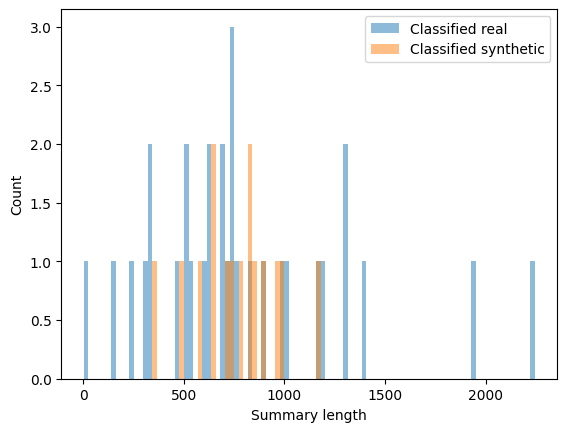

In [21]:
fig, ax = plt.subplots()

bins = np.linspace(new["text_length"].min(), new["text_length"].max(), 100)

x1 = new[new["predicted"]=="real"]["text_length"]
x2 = new[new["predicted"]=="synthetic"]["text_length"]

ax.hist(x1, bins, label="Classified real", alpha=0.5)
ax.hist(x2, bins, label="Classified synthetic", alpha=0.5)

ax.set_ylabel("Count")
ax.set_xlabel("Summary length")

ax.legend()

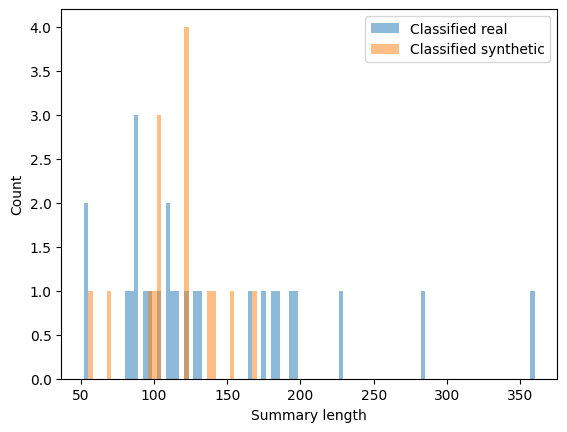

In [22]:
fig, ax = plt.subplots()

bins = np.linspace(copied["text_length"].min(), copied["text_length"].max(), 100)


x1 = copied[copied["predicted"]=="real"]["text_length"]
x2 = copied[copied["predicted"]=="synthetic"]["text_length"]

ax.hist(x1, bins, label="Classified real", alpha=0.5)
ax.hist(x2, bins, label="Classified synthetic", alpha=0.5)

ax.set_ylabel("Count")
ax.set_xlabel("Summary length (words)")

ax.legend()